In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import yaml
from pathlib import Path
from mne_bids import BIDSPath
from mne.time_frequency import tfr_morlet

from plotting import plot_roc_multiclass_cv, plot_feature_importances
from functions.move_experiment_functions import get_event_data
from functions.time_window_selection_functions import get_event_durations

%load_ext autoreload
%autoreload 2

In [2]:
with open(Path(os.path.abspath('')) / "config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

with open(Path(os.path.abspath('')) / "metadata.yml") as f:
    metadata = yaml.load(f, Loader=yaml.FullLoader)

subjects = metadata["subjects"]

bids_root = Path(config["bids_root"])
results_path = Path(config["results_path"])

print(f"bids_root: {bids_root}")
print(f"results_path: {results_path}")

bids_root: /Volumes/Mac/research/data/efri
results_path: /Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/workstation_output


In [3]:
subject = "efri07"
clf_name = "MT-MORF"
path_identifiers = dict(subject=subject, session="efri", task="move", 
                        acquisition="seeg", run="01", suffix="ieeg", 
                        extension=".vhdr", root=bids_root)
bids_path = BIDSPath(**path_identifiers)

In [4]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.0  # different number of cycle per frequency
rng = 1

## Feature Importances (Time Domain) Trial Specific Window

In [5]:
go_cue_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=-1
)
left_target_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=1
)

tmin = -max(go_cue_durations)
tmax = max(left_target_durations)

epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

data = epochs.get_data()
ntrials, nchs, nsteps = data.shape
print(f"{subject.upper()}: data.shape = ({data.shape})")

t = epochs.times
mask = (t >= -np.asarray(go_cue_durations)[:, None, None]) & (
    t <= np.asarray(left_target_durations)[:, None, None]
)
masked_data = data * mask

image_height = nchs
image_width = nsteps

Extracting parameters from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Reading 0 ... 2613999  =      0.000 ...  1306.999 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)

Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Targe

In [6]:
X = masked_data.reshape(ntrials, -1)
y = labels
X.shape, y.shape

((76, 131100), (76,))

In [7]:
filename = results_path / subject / f"trial_specific_window/time_domain/{subject}_{clf_name}_results.json"
with open(filename) as f:
    scores = json.load(f)

scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params', 'validate_roc_auc_ovr_imp_mean', 'validate_roc_auc_ovr_imp_std'])

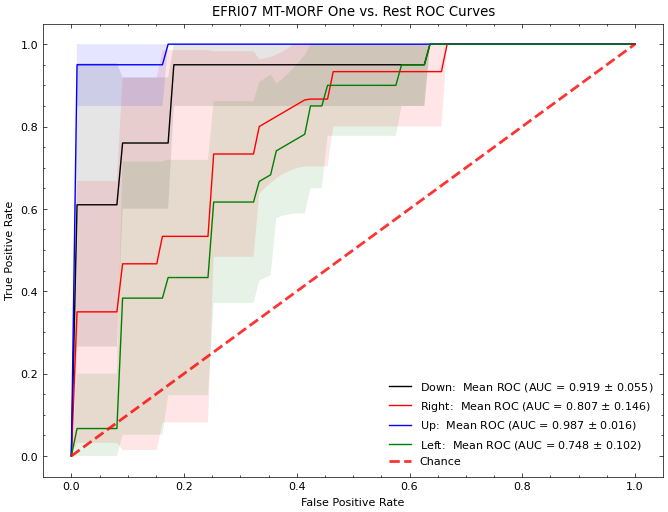

In [8]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
plot_roc_multiclass_cv(
    scores["test_predict_proba"],
    X,
    y,
    scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} {clf_name} One vs. Rest ROC Curves",
)
ax.legend(loc="lower right");

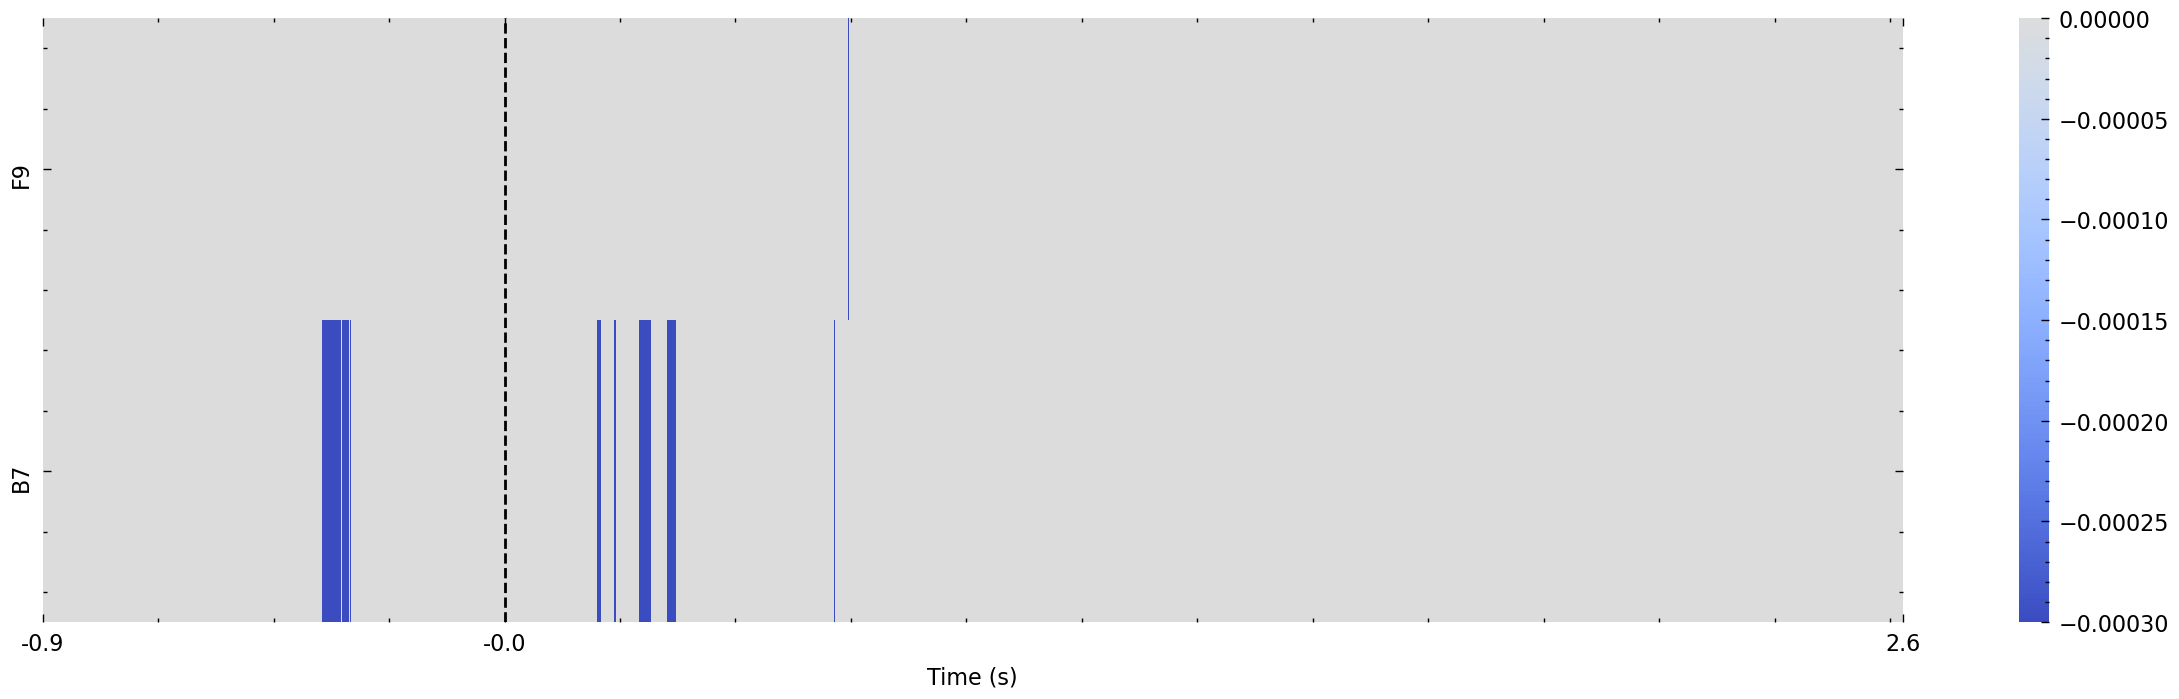

In [9]:
scoring_method = "roc_auc_ovr"
result = dict(
    importances_mean=np.array(scores[f"validate_{scoring_method}_imp_mean"]), 
    importances_std=np.array(scores[f"validate_{scoring_method}_imp_std"]
))

importances_mean = np.array(result["importances_mean"]).reshape(image_height, image_width)
significant_chs = np.where(~np.isclose(np.sum(np.abs(importances_mean), axis=1), 0))[0]

subsetted_results = dict(
    importances_mean=result["importances_mean"].reshape(image_height, image_width)[significant_chs],
    importances_std=result["importances_std"].reshape(image_height, image_width)[significant_chs]
)

fig, ax = plt.subplots(dpi=200, figsize=(15, 4))
plot_feature_importances(subsetted_results, np.array(epochs.ch_names)[significant_chs], epochs.times, len(significant_chs), image_width, vmin=-3e-4, vmax=0.0, ax=ax);

## Feature Importances (Freq Domain) Trial Specific Window

In [10]:
go_cue_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=-1
)
left_target_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=1
)

tmin = -max(go_cue_durations)
tmax = max(left_target_durations)

epochs, labels = get_event_data(bids_path, tmin=tmin - 0.2, tmax=tmax + 0.2)

power = tfr_morlet(
            epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            average=False,
            return_itc=False,
            decim=3,
            n_jobs=-1,
)
power.crop(tmin=tmin, tmax=tmax)
data = power.data
ntrials, nchs, nfreqs, nsteps = data.shape
print(f"{subject.upper()}: data.shape = ({data.shape})")

t = power.times
mask = (t >= -np.asarray(go_cue_durations)[:, None, None, None]) & (
    t <= np.asarray(left_target_durations)[:, None, None, None]
)
masked_data = data * mask

image_height = nchs * nfreqs
image_width = nsteps

Extracting parameters from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Reading 0 ... 2613999  =      0.000 ...  1306.999 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)

Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Targe

In [11]:
X = masked_data.reshape(ntrials, -1)
y = labels
X.shape, y.shape

((76, 387000), (76,))

In [12]:
filename = results_path / subject / f"trial_specific_window/freq_domain/{subject}_{clf_name}_results.json"
with open(filename) as f:
    scores = json.load(f)

scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params', 'validate_roc_auc_ovr_imp_mean', 'validate_roc_auc_ovr_imp_std'])

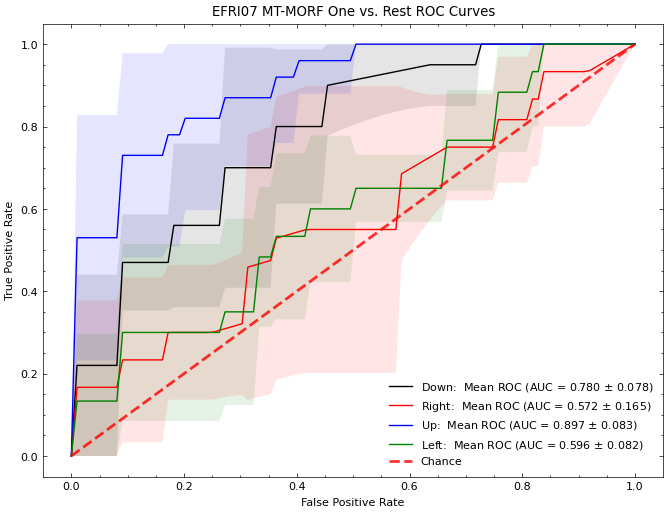

In [13]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
plot_roc_multiclass_cv(
    scores["test_predict_proba"],
    X,
    y,
    scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} {clf_name} One vs. Rest ROC Curves",
)
ax.legend(loc="lower right");

In [14]:
# scoring_method = "roc_auc_ovr"
# result = dict(
#     importances_mean=np.array(scores[f"validate_{scoring_method}_imp_mean"]), 
#     importances_std=np.array(scores[f"validate_{scoring_method}_imp_std"]
# ))

# importances_mean = np.array(result["importances_mean"]).reshape(image_height, image_width)
# significant_chs = np.where(~np.isclose(np.sum(np.abs(importances_mean), axis=1), 0))[0]
# ordering = np.argsort(np.count_nonzero(importances_mean[significant_chs], axis=1))[::-1]
# significant_chs = significant_chs[ordering]

# power_ch_names = [f"{ch}-{f:.2f}" for ch in power.ch_names for f in freqs]
# subsetted_results = dict(
#     importances_mean=result["importances_mean"].reshape(image_height, image_width)[significant_chs],
#     importances_std=result["importances_std"].reshape(image_height, image_width)[significant_chs]
# )

# fig, ax = plt.subplots(dpi=100, figsize=(15, 50))
# plot_feature_importances(subsetted_results, np.array(power_ch_names)[significant_chs], power.times, len(significant_chs), image_width, ax=ax)
# ax.set(title=f"{subject.upper()}: Permutation Importance")

# filename = results_path / subject / f"trial_specific_window/freq_domain/{subject}_{clf_name}_features_importances_significant_chs_freqs_{scoring_method}.png"
# plt.savefig(filename);

## Feature Importances (Freq Domain) -0.5s to 1.0s window

In [15]:
go_cue_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=-1
)
left_target_durations = get_event_durations(
    bids_path, event_key="Left Target", periods=1
)

tmin, tmax = -0.5, 1.0
epochs, labels = get_event_data(bids_path, tmin=tmin, tmax=tmax)
power = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    average=False,
    return_itc=False,
    decim=3,
    n_jobs=-1,
)

data = power.data
ntrials, nchs, nfreqs, nsteps = data.shape
print(f"{subject.upper()}: data.shape = ({data.shape})")

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]

image_height = nchs * nfreqs
image_width = nsteps

Extracting parameters from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/Mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Reading 0 ... 2613999  =      0.000 ...  1306.999 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)

Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Targe

In [16]:
X = masked_data.reshape(ntrials, -1)
y = labels
X.shape, y.shape

((76, 387000), (76,))

In [17]:
filename = results_path / subject / f"{subject}_{clf_name}_results.json"
with open(filename) as f:
    scores = json.load(f)

scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params', 'validate_roc_auc_ovr_imp_mean', 'validate_roc_auc_ovr_imp_std'])

In [18]:
X = data.reshape(ntrials, -1)
y = labels
X.shape, y.shape

((76, 187500), (76,))

In [19]:
# scoring_method = "roc_auc_ovr"
# result = dict(
#     importances_mean=np.array(scores[f"validate_{scoring_method}_imp_mean"]), 
#     importances_std=np.array(scores[f"validate_{scoring_method}_imp_std"]
# ))

# importances_mean = np.array(result["importances_mean"]).reshape(image_height, image_width)
# significant_chs = np.where(~np.isclose(np.sum(np.abs(importances_mean), axis=1), 0))[0]
# ordering = np.argsort(np.count_nonzero(importances_mean[significant_chs], axis=1))[::-1]
# significant_chs = significant_chs[ordering]

# power_ch_names = [f"{ch}-{f:.2f}" for ch in power.ch_names for f in freqs]
# subsetted_results = dict(
#     importances_mean=result["importances_mean"].reshape(image_height, image_width)[significant_chs],
#     importances_std=result["importances_std"].reshape(image_height, image_width)[significant_chs]
# )

# fig, ax = plt.subplots(dpi=100, figsize=(15, 50))
# plot_feature_importances(subsetted_results, np.array(power_ch_names)[significant_chs], power.times, len(significant_chs), image_width, ax=ax)
# ax.set(title=f"{subject.upper()}: Permutation Importance")

# filename = results_path / subject / f"{subject}_{clf_name}_features_importances_significant_chs_freqs_{scoring_method}.png"
# plt.savefig(filename);